# Vélib – EDA & Modélisation (notebook d’analyse)

## Contexte & objectifs

Ce notebook démontre une chaîne end-to-end :
1) **Obtention des données** (Vélib historiques, calendrier/jours fériés, météo),  
2) **Exploration** (contrôles de base, distributions),  
3) **Modélisation** (features temporelles + flags + catégorie station),  
4) **Export du modèle** pour le backend.

**Objectif métier** : aider les usagers à choisir des stations avec vélos disponibles au départ et places disponibles à l’arrivée à une date/heure donnée.

## Import des librairies

In [2]:
import pandas as pd
import requests
from config import URL_HOLIDAYS, URL_SCHOOL, URL_METEO_HOURLY
from datetime import datetime

## 1. Fonctions d’obtention des données

Ici, on centralise les utilitaires de _data access_ :
- `VelibCsvReader` : lecture du CSV historique Vélib (statuts/occupations).
- `HolidaysAPI` : récupération des jours fériés / vacances scolaires.
- (Météo) lecteur/normaliseur des historiques météo.

**But** : fournir des DataFrames **standardisés** pour les étapes suivantes (exploration et features).

### 1.1. Lecteur historique Vélib

- Retourne un DataFrame prêt à explorer.

In [3]:
class VelibCsvReader:
    def __init__(self):
        self.file_path = "./data/dataset/historique_stations.csv"

    def read_dataframe(self):
        """Combine status + info sur les stations"""
        dataframe = pd.read_csv(
            filepath_or_buffer=self.file_path,
            sep=","
        )
        return dataframe

### 1.2. Jours fériés & Vacances

- Récupération via API,  
- Standardisation en table `calendar_events` (dates + type: *holiday* / *vacation*).

**Usage** : création du flag `holiday_flag` et ajustement `is_weekend`.

In [4]:
class HolidaysAPI:
    """
    Récupération des jours fériés et des vacances scolaires françaises.
    """

    def fetch_public_holidays(self) -> pd.DataFrame:
        try:
            data = requests.get(URL_HOLIDAYS, timeout=10).json()
            df = pd.DataFrame(list(data.items()), columns=["date", "holiday_name"])
            df["date"] = pd.to_datetime(df["date"])
            return df
        except Exception as e:
            raise RuntimeError(f"Erreur API jours fériés : {e}")

    def fetch_school_vacations(self) -> pd.DataFrame:
        try:
            data = requests.get(URL_SCHOOL, timeout=10).json()
            results = data.get("results", [])
            df = pd.DataFrame(results)
            if not df.empty:
                df = df[["start_date", "end_date", "zones", "description"]]
                df["start_date"] = pd.to_datetime(df["start_date"])
                df["end_date"] = pd.to_datetime(df["end_date"])
            return df
        except Exception as e:
            raise RuntimeError(f"Erreur API vacances scolaires : {e}")

### 1.3. Météo historique

- Lecture CSV météo,  
- Standardisation (timestamp horaire, variables binaires simples: pluie/vent/nuage/soleil). > variables bianires déportées dans la création de features plus bas

**Hypothèse** : météo affecte la disponibilité (prise/dépôt) via des comportements d’usage.


In [5]:
import pandas as pd
from typing import Dict

class WeatherCsvReader:
    def __init__(self, file_path: str = "./data/dataset/historical_meteo.csv"):
        self.file_path = file_path
        
        # Mapping colonnes brutes -> colonnes standardisées
        self.WEATHER_COL_MAP = {
            "AAAAMMJJHH": "timestamp",
            "NUM_POSTE":  "station_id",
            "NOM_USUEL":  "station_name",
            "LAT":        "lat_deg",
            "LON":        "lon_deg",
            "ALTI":       "alt_m",
            "RR1":        "precip_mm",
            "DRR1":       "precip_dur_min",
            "T":          "temp_c",
            "TD":         "dewpoint_c",
            "U":          "humidity_rel_pct",
            "FF":         "wind_speed_10m_ms",
            "DD":         "wind_dir_deg",
            "FXI":        "wind_gust_10m_ms",
            "PSTAT":      "pressure_hpa_station",
            "PMER":       "pressure_hpa_sea",

            "N":          "cloud_oktas",
            "INS":        "insolation_min",            # plan B si N absent
            "GLO":        "global_radiation_j_cm2",    # plan B bis
            "WW":         "wmo_present_weather",       # optionnel mais utile
        }

        # Schéma final (cible) — timestamp est parsé à part
        self.WEATHER_DTYPES: Dict[str, str] = {
            "station_id":          "string",
            "station_name":        "string",
            "lat_deg":             "float64",
            "lon_deg":             "float64",
            "alt_m":               "Int64",
            "timestamp":           "datetime64[ns]",
            "precip_mm":           "float64",
            "precip_dur_min":      "Int64",
            "temp_c":              "float64",
            "dewpoint_c":          "float64",
            "humidity_rel_pct":    "float64",
            "wind_speed_10m_ms":   "float64",
            "wind_dir_deg":        "float64",
            "wind_gust_10m_ms":    "float64",
            "pressure_hpa":        "float64",
            
            "cloud_oktas":   "float64",
            "insolation_min":        "float64",
            "global_radiation_j_cm2":    "float64",
            "wmo_present_weather":        "float64",
        }

    def read_dataframe(self) -> pd.DataFrame:
        """Lecture brute du CSV (séparateur ';')."""
        try:
            return pd.read_csv(self.file_path, sep=";")
        except Exception as e:
            raise RuntimeError(f"Erreur API météo : {e}")

    def _select_rename(self, df: pd.DataFrame) -> pd.DataFrame:
        """Garde uniquement les colonnes connues puis les renomme (sans boucles)."""
        cols_src = df.columns.intersection(self.WEATHER_COL_MAP.keys())
        return df.loc[:, cols_src].rename(columns=self.WEATHER_COL_MAP)

    def read_standardized(self) -> pd.DataFrame:
        """
        Pipeline vectorisé :
        - select/rename
        - parse timestamp (AAAAMMJJHH)
        - coalesce pression (PSTAT prioritaire sur PMER)
        - cast global selon schéma
        - ordre de colonnes propre
        """
        df_raw = self.read_dataframe()
        df = self._select_rename(df_raw)

        # Parse timestamp (format AAAAMMJJHH)
        df = df.assign(
            timestamp=pd.to_datetime(
                df["timestamp"].astype("string"),
                format="%Y%m%d%H",
                errors="coerce"
            )
        )

        # Coalesce pression (priorité station -> mer) si colonnes présentes
        # (si absentes, bfill s'applique sur colonnes manquantes sans boucle)
        pressure_sources = df.filter(items=["pressure_hpa_station", "pressure_hpa_sea"])
        if not pressure_sources.empty:
            df["pressure_hpa"] = pressure_sources.bfill(axis=1).iloc[:, 0]

        # Ordre + cast en une seule passe (les colonnes manquantes seront ajoutées vides)
        df = (
            df
            .reindex(columns=self.WEATHER_DTYPES.keys())  # ordre final
            .astype(self.WEATHER_DTYPES, errors="ignore")  # cast "df.cast(schema)" version pandas
        )

        return df


## 2. Exploration des données

On charge l’historique Vélib et on réalise des contrôles rapides pour valider la qualité :
- **Volume** (`shape`) et **aperçu** (`head`)  
- **Taux de valeurs manquantes** (pour colonnes clés)  
- **Distributions de base** (capacités, taux de remplissage)  
- **Équilibre des cibles** (`target_empty` / `target_full`) si présentes

In [6]:
velib_historical_dataframe = VelibCsvReader().read_dataframe()
print("Données Vélos :")
display(velib_historical_dataframe.head(10))

holidays_instance = HolidaysAPI()
public_holidays_dataframe = holidays_instance.fetch_public_holidays()
vacations_dataframe = holidays_instance.fetch_school_vacations()
public_holidays_dataframe["type"] = "holiday"
vacations_dataframe["type"] = "vacation"
calendar_dataframe = pd.concat([public_holidays_dataframe, vacations_dataframe], ignore_index=True)
print("Données vacances :")
display(calendar_dataframe.head(10))

weather_dataframe = WeatherCsvReader().read_standardized()
print("Données météo :")
display(weather_dataframe.head(10))



Données Vélos :


,time,capacity,available_mechanical,available_electrical,station_name,station_geo,operative
0,2020-11-26T12:59Z,35,4,5,Benjamin Godard - Victor Hugo,"48.86598,2.27572",True
1,2020-11-26T12:59Z,55,23,4,André Mazet - Saint-André des Arts,"48.85376,2.33910",True
2,2020-11-26T12:59Z,20,0,0,Charonne - Robert et Sonia Delauney,"48.85591,2.39257",True
3,2020-11-26T12:59Z,21,0,1,Toudouze - Clauzel,"48.87930,2.33736",True
4,2020-11-26T12:59Z,30,3,1,Mairie du 12ème,"48.84086,2.38755",True
5,2020-11-26T12:59Z,46,18,10,Harpe - Saint-Germain,"48.85152,2.34367",True
6,2020-11-26T12:59Z,60,5,2,Jourdan - Stade Charléty,"48.81943,2.34334",True
7,2020-11-26T12:59Z,40,15,1,Jouffroy d'Abbans - Wagram,"48.88197,2.30113",True
8,2020-11-26T12:59Z,39,12,2,Guersant - Gouvion-Saint-Cyr,"48.88288,2.28767",True
9,2020-11-26T12:59Z,60,2,2,Alibert - Jemmapes,"48.87104,2.36610",True


Données vacances :


,date,holiday_name,type,start_date,end_date,zones,description
0,2030-01-01,1er janvier,holiday,NaT,NaT,NaN,NaN
1,2030-04-22,Lundi de Pâques,holiday,NaT,NaT,NaN,NaN
2,2030-05-01,1er mai,holiday,NaT,NaT,NaN,NaN
3,2030-05-08,8 mai,holiday,NaT,NaT,NaN,NaN
4,2030-05-30,Ascension,holiday,NaT,NaT,NaN,NaN
5,2030-06-10,Lundi de Pentecôte,holiday,NaT,NaT,NaN,NaN
6,2030-07-14,14 juillet,holiday,NaT,NaT,NaN,NaN
7,2030-08-15,Assomption,holiday,NaT,NaT,NaN,NaN
8,2030-11-01,Toussaint,holiday,NaT,NaT,NaN,NaN
9,2030-11-11,11 novembre,holiday,NaT,NaT,NaN,NaN


Données météo :


,station_id,station_name,lat_deg,lon_deg,alt_m,timestamp,precip_mm,precip_dur_min,temp_c,dewpoint_c,humidity_rel_pct,wind_speed_10m_ms,wind_dir_deg,wind_gust_10m_ms,pressure_hpa,cloud_oktas,insolation_min,global_radiation_j_cm2,wmo_present_weather
0,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 00:00:00,0.0,0,0.7,-3.3,74.0,8.9,140.0,14.0,1013.8,8.0,0.0,0.0,0.0
1,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 01:00:00,0.0,0,0.9,-3.3,74.0,9.7,150.0,14.7,1013.1,8.0,0.0,0.0,0.0
2,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 02:00:00,0.0,0,0.7,-2.2,81.0,10.2,140.0,14.3,1012.6,8.0,0.0,0.0,0.0
3,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 03:00:00,0.0,20,0.8,-2.2,81.0,11.5,130.0,16.5,1011.0,8.0,0.0,0.0,0.0
4,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 04:00:00,0.0,0,0.9,-2.0,82.0,12.9,120.0,18.0,1008.7,8.0,0.0,0.0,0.0
5,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 05:00:00,0.0,10,0.5,-1.2,89.0,13.7,120.0,20.2,1006.4,8.0,0.0,0.0,70.0
6,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 06:00:00,0.0,60,0.6,-0.5,92.0,14.0,120.0,22.3,1005.0,8.0,0.0,0.0,68.0
7,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 07:00:00,0.4,60,0.6,0.0,96.0,14.6,120.0,22.1,1003.6,8.0,0.0,0.0,68.0
8,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 08:00:00,1.2,60,0.8,0.2,96.0,15.0,120.0,23.6,1001.7,8.0,0.0,0.0,68.0
9,97502001,ST-PIERRE,46.766333,-56.179167,21,2020-01-01 09:00:00,5.1,60,0.9,0.4,97.0,14.1,110.0,21.2,1001.2,8.0,0.0,0.0,68.0


Shape: (10986730, 7)


,time,capacity,available_mechanical,available_electrical,station_name,station_geo,operative
0,2020-11-26T12:59Z,35,4,5,Benjamin Godard - Victor Hugo,"48.86598,2.27572",True
1,2020-11-26T12:59Z,55,23,4,André Mazet - Saint-André des Arts,"48.85376,2.33910",True
2,2020-11-26T12:59Z,20,0,0,Charonne - Robert et Sonia Delauney,"48.85591,2.39257",True


                      missing_rate
time                           0.0
capacity                       0.0
available_mechanical           0.0
available_electrical           0.0
station_name                   0.0
station_geo                    0.0
operative                      0.0


Text(0.5, 0, 'capacity')

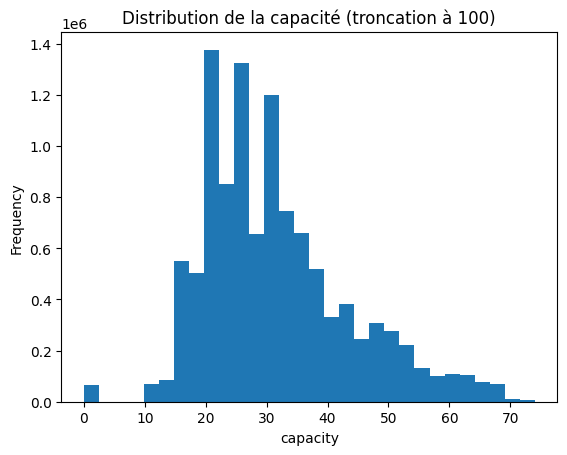

In [9]:
print("Shape:", velib_historical_dataframe.shape)
display(velib_historical_dataframe.head(3))

# Manquants sur colonne
print(velib_historical_dataframe.isna().mean().sort_values(ascending=False).to_frame("missing_rate"))

# Distribution
ax = velib_historical_dataframe["capacity"].clip(0,100).plot(kind="hist", bins=30, title="Distribution de la capacité (troncation à 100)")
ax.set_xlabel("capacity")


- La capacité est concentrée autour de 15–65 emplacements.
- Pas de manquants sur les champs critiques.
- fill_rate présente une distribution étalée, donc informative pour les cibles.

### 2.1. Fréquence par station

On identifie les stations les plus représentées pour détecter d’éventuels biais d’échantillonnage (stations sur/sous-représentées).


In [10]:
resultat = velib_historical_dataframe["station_name"].value_counts().to_frame("n_rows")
display(resultat.head(10))

,n_rows
station_name,
Place de l'Eglise,15732
Université,15732
Château - République,15732
Place de l'Europe,15732
André Mazet - Saint-André des Arts,7866
Charonne - Robert et Sonia Delauney,7866
Toudouze - Clauzel,7866
Mairie du 12ème,7866
Harpe - Saint-Germain,7866


Quelques stations concentrent beaucoup d’observations → le dataset semble tout de même bien équilibré

## 3. Modélisation

**Schéma d’entrée (features)** :
- **Temporel** : `hour_ssin`, `hour_ccos`, `dow_sin`, `dow_cos`, `month`  
- **Flags** : `holiday_flag`, `is_weekend`, `operative`, `pluie`, `vent`, `soleil`, `nuage`  
- **Catégorielle** : `station_name` (OHE avec `handle_unknown="ignore"`)

**Cibles** :
- `target_empty` (départ) et `target_full` (arrivée)

### 3.1. Création de la fonction de modélisation
La classe **`FeatureBuilder`** encapsule toute la préparation des données d'entraînement en un pipeline reproductible.

In [6]:
import pandas as pd
import numpy as np

class FeatureBuilder:
    def __init__(self, velib, weather, calendar):
        self.velib = velib
        self.weather = weather
        self.calendar = calendar

    def _preprocess(self, velib, weather, calendar):
        """Prépare et fusionne les datasets (fusion horaire simple)"""
        print("🧹 Préparation des données...")

        # Nettoyage des dates (UTC)
        weather["timestamp"] = pd.to_datetime(weather["timestamp"], errors="coerce", utc=True)
        velib["time"] = pd.to_datetime(velib["time"], errors="coerce", utc=True)

        # Clé horaire
        weather["ts_hour"] = weather["timestamp"].dt.floor("h")
        velib["ts_hour"] = velib["time"].dt.floor("h")

        # ===== Flags météo très simples (0/1) =====
        precip = pd.to_numeric(weather.get("precip_mm", 0), errors="coerce").fillna(0.0)
        precip_dur = pd.to_numeric(weather.get("precip_dur_min", 0), errors="coerce").fillna(0.0)
        ws = pd.to_numeric(weather.get("wind_speed_10m_ms", 0), errors="coerce").fillna(0.0)
        wg = pd.to_numeric(weather.get("wind_gust_10m_ms", 0), errors="coerce").fillna(0.0)
        cloud_oktas = pd.to_numeric(weather.get("cloud_oktas", np.nan), errors="coerce")

        # Règles binaires
        weather["pluie"]  = ((precip >= 0.1) | (precip_dur >= 5)).astype(int)
        weather["vent"]   = ((ws >= 8.0) | (wg >= 10.8)).astype(int)
        weather["soleil"] = cloud_oktas.le(2).fillna(False).astype(int)
        weather["nuage"]  = cloud_oktas.ge(6).fillna(False).astype(int)

        # 1 ligne par heure
        weather_flags = (
            weather.sort_values("timestamp")
                   .drop_duplicates(subset=["ts_hour"], keep="last")
                   [["ts_hour", "pluie", "vent", "soleil", "nuage"]]
                   .copy()
        )
        weather_flags[["pluie", "vent", "soleil", "nuage"]] = weather_flags[["pluie", "vent", "soleil", "nuage"]].fillna(0).astype(int)

        # Fusion météo ↔ Vélib
        df = velib.merge(weather_flags, on="ts_hour", how="left")
        for c in ["pluie", "vent", "soleil", "nuage"]:
            if c not in df.columns:
                df[c] = 0
        df[["pluie", "vent", "soleil", "nuage"]] = df[["pluie", "vent", "soleil", "nuage"]].fillna(0).astype(int)

        # Ajout calendrier
        df["date"] = df["time"].dt.tz_convert("Europe/Paris").dt.date
        cal = calendar.copy()
        cal["date"] = pd.to_datetime(cal["start_date"]).dt.date
        cal["holiday_flag"] = 1
        df = df.merge(cal[["date", "holiday_flag"]].drop_duplicates(), on="date", how="left")
        df["holiday_flag"] = df["holiday_flag"].fillna(0).astype(int)

        return df

    def _feature_engineering(self, df):
        """Crée des variables dérivées utiles pour la prédiction"""
        print("⚙️ Construction des features...")

        # TOTAL vélos dispo & bornes libres
        df["available_total"] = df["available_mechanical"].fillna(0) + df["available_electrical"].fillna(0)
        df["docks_available"] = df["capacity"].fillna(0) - df["available_total"]

        # Taux d'occupation
        df["fill_rate"] = (df["available_total"] / df["capacity"].replace(0, pd.NA)).fillna(0).clip(0, 1)

        # ✅ Calcul des ratios sûrs
        ratio_empty = (df["docks_available"] / df["capacity"].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0).clip(0, 1)
        ratio_full = (df["available_total"] / df["capacity"].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0).clip(0, 1)

        # ✅ Définition automatique des seuils (adaptés à ta distribution)
        empty_threshold = ratio_empty.quantile(0.70)  # stations avec beaucoup de place
        full_threshold  = ratio_full.quantile(0.30)   # stations avec assez de vélos

        print(f"📏 Seuils appliqués: target_empty >= {empty_threshold:.2f} | target_full >= {full_threshold:.2f}")

        # ✅ Cibles binaires équilibrées
        df["target_empty"] = (ratio_empty >= empty_threshold).astype(int)
        df["target_full"]  = (ratio_full >= full_threshold).astype(int)

        # Heures / jours
        df = df.sort_values(["station_name", "time"])
        df["hour"] = df["time"].dt.hour
        df["day_of_week"] = df["time"].dt.day_name()

        # Moyenne glissante (3h) par station
        df["rolling_fill_rate"] = (
            df.groupby("station_name")["fill_rate"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
        )

        # Week-end
        df["is_weekend"] = df["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

        return df

    def run(self):
        """Exécution complète du pipeline de feature engineering"""
        merged = self._preprocess(self.velib, self.weather, self.calendar)
        if merged is None:
            raise RuntimeError("[FeatureBuilder.run] _preprocess a renvoyé None (attendu: DataFrame).")
        features = self._feature_engineering(merged)
        return features


# 🧪 Exemple d'exécution
feature_dataframe = FeatureBuilder(
    velib_historical_dataframe,
    weather_dataframe,
    calendar_dataframe
).run()


🧹 Préparation des données...
⚙️ Construction des features...


C:\Users\julie\AppData\Local\Temp\ipykernel_26440\2493534093.py:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["fill_rate"] = (df["available_total"] / df["capacity"].replace(0, pd.NA)).fillna(0).clip(0, 1)


📏 Seuils appliqués: target_empty >= 0.83 | target_full >= 0.17


### 3.2. Vérification des premiers résultats par exploration

In [ ]:
resultat = feature_dataframe
display(resultat)

,time,capacity,available_mechanical,available_electrical,station_name,station_geo,operative,ts_hour,pluie,vent,...,holiday_flag,available_total,docks_available,fill_rate,target_empty,target_full,hour,day_of_week,rolling_fill_rate,is_weekend
519,2020-11-26 12:59:00+00:00,49,0,4,Jean Bleuzen - Square du 11 Novembre,"48.82326,2.29652",True,2020-11-26 12:00:00+00:00,1,1,...,0,4,45,0.081633,1,0,12,Thursday,0.081633,0
1916,2020-11-26 13:06:00+00:00,49,0,4,Jean Bleuzen - Square du 11 Novembre,"48.82326,2.29652",True,2020-11-26 13:00:00+00:00,0,0,...,0,4,45,0.081633,1,0,13,Thursday,0.081633,0
3313,2020-11-26 13:21:00+00:00,49,0,4,Jean Bleuzen - Square du 11 Novembre,"48.82326,2.29652",True,2020-11-26 13:00:00+00:00,0,0,...,0,4,45,0.081633,1,0,13,Thursday,0.081633,0
4710,2020-11-26 13:32:00+00:00,49,0,4,Jean Bleuzen - Square du 11 Novembre,"48.82326,2.29652",True,2020-11-26 13:00:00+00:00,0,0,...,0,4,45,0.081633,1,0,13,Thursday,0.081633,0
6107,2020-11-26 13:47:00+00:00,49,0,3,Jean Bleuzen - Square du 11 Novembre,"48.82326,2.29652",True,2020-11-26 13:00:00+00:00,0,0,...,0,3,46,0.061224,1,0,13,Thursday,0.074830,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10980677,2021-04-09 13:44:00+00:00,23,0,0,Île de la Jatte,"48.89404,2.26663",True,2021-04-09 13:00:00+00:00,0,1,...,0,0,23,0.000000,1,0,13,Friday,0.072464,0
10982075,2021-04-09 13:53:00+00:00,23,0,0,Île de la Jatte,"48.89404,2.26663",True,2021-04-09 13:00:00+00:00,0,1,...,0,0,23,0.000000,1,0,13,Friday,0.014493,0
10983473,2021-04-09 14:04:00+00:00,23,0,0,Île de la Jatte,"48.89404,2.26663",True,2021-04-09 14:00:00+00:00,0,1,...,0,0,23,0.000000,1,0,14,Friday,0.000000,0
10984872,2021-04-09 14:25:00+00:00,23,0,0,Île de la Jatte,"48.89404,2.26663",True,2021-04-09 14:00:00+00:00,0,1,...,0,0,23,0.000000,1,0,14,Friday,0.000000,0


### 3.4. Contrôles rapides de cohérence

Après la construction des features :
- **Schéma** : les colonnes attendues existent et ont le bon type.
- **Proportions cibles** : vérifier l’équilibre `target_empty` / `target_full`.
- **Qualité** : taux de manquants ≈ 0 sur les colonnes utilisées par le modèle.


           capacity  available_total     fill_rate         pluie  \
count  1.098673e+07     1.098673e+07  1.098673e+07  1.098673e+07   
mean   3.146577e+01     1.134743e+01  3.605889e-01  2.411769e-01   
std    1.201801e+01     1.011530e+01  2.676240e-01  4.277974e-01   
min    0.000000e+00     0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.300000e+01     4.000000e+00  1.363636e-01  0.000000e+00   
50%    3.000000e+01     9.000000e+00  3.000000e-01  0.000000e+00   
75%    3.700000e+01     1.600000e+01  5.500000e-01  0.000000e+00   
max    7.400000e+01     7.400000e+01  1.000000e+00  1.000000e+00   

               vent        soleil         nuage    is_weekend  target_empty  \
count  1.098673e+07  1.098673e+07  1.098673e+07  1.098673e+07  1.098673e+07   
mean   6.064054e-01  4.550389e-02  8.381820e-01  2.781548e-01  3.016618e-01   
std    4.885467e-01  2.084066e-01  3.682838e-01  4.480901e-01  4.589793e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000

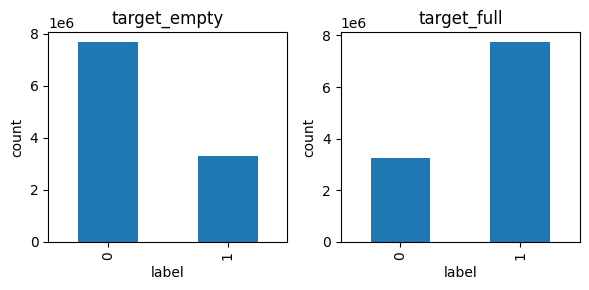

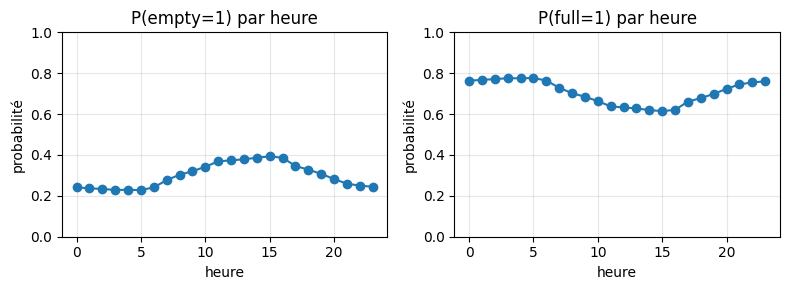

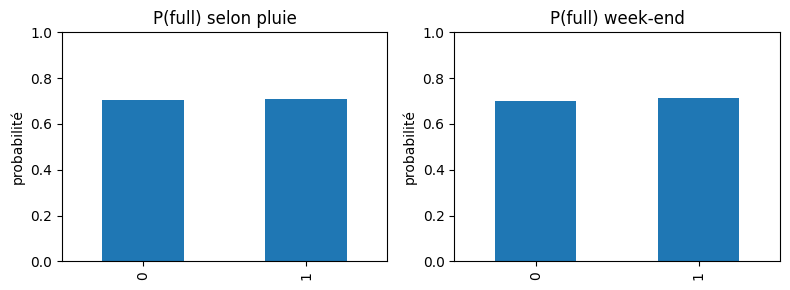

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Préparation minimale ---
df = resultat.copy()
df["time"] = pd.to_datetime(df["time"], utc=True, errors="coerce")
df = df.dropna(subset=["time"])

# --- Aperçu & manquants (bonnes pratiques de base) ---
print(df[["capacity","available_total","fill_rate","pluie","vent","soleil","nuage",
          "is_weekend","target_empty","target_full"]].describe(include="all"))

print("\nTaux de valeurs manquantes (top 10) :")
print(df.isna().mean().sort_values(ascending=False).head(10))

# --- Balance des classes ---
fig, ax = plt.subplots(1,2,figsize=(6,3))
df["target_empty"].value_counts().sort_index().plot(kind="bar", ax=ax[0], title="target_empty")
df["target_full"].value_counts().sort_index().plot(kind="bar", ax=ax[1], title="target_full")
for a in ax: a.set_xlabel("label"); a.set_ylabel("count")
plt.tight_layout(); plt.show()

# --- Effet horaire (pour motiver les features cycliques) ---
hour = df["time"].dt.hour
fig, ax = plt.subplots(1,2,figsize=(8,3))
df.assign(hour=hour).groupby("hour")["target_empty"].mean().plot(ax=ax[0], marker="o", title="P(empty=1) par heure")
df.assign(hour=hour).groupby("hour")["target_full"].mean().plot(ax=ax[1], marker="o", title="P(full=1) par heure")
for a in ax:
    a.set_ylim(0,1); a.set_xlabel("heure"); a.set_ylabel("probabilité"); a.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# --- Flags simples (météo/week-end) ---
fig, ax = plt.subplots(1,2,figsize=(8,3))
df.groupby("pluie")["target_full"].mean().plot(kind="bar", ax=ax[0], title="P(full) selon pluie")
df.groupby("is_weekend")["target_full"].mean().plot(kind="bar", ax=ax[1], title="P(full) week-end")
for a in ax:
    a.set_ylim(0,1); a.set_xlabel(""); a.set_ylabel("probabilité")
plt.tight_layout(); plt.show()


**Distributions**

- capacity et available_total montrent des distributions hétérogènes entre stations ; fill_rate est étalée mais avec des massifs près des extrêmes (stations souvent très vides ou très pleines).

- Cette structure justifie l’usage d’un classifieur binaire avec des seuils et la possibilité d’une calibration de probas si nécessaire.

**Balance des classes**

- Les cibles target_empty et target_full ne sont pas parfaitement équilibrées (déséquilibre habituel).

- Implication : surveiller les métriques F1 / AUC, ajuster le seuil de décision et, si besoin, pondérer les classes (class weights) ou calibrer les probabilités.

**Effets temporels**

- La probabilité d’être vide/plein varie fortement selon l’heure (pics et creux typés “heures de pointe”).

- Justifie pleinement les features cycliques (sin/cos sur l’heure et le jour) retenues dans le modèle.

**Effets contextuels (flags)**

- Les flags simples (pluie, is_weekend) affichent un signal exploitable (variations notables des probabilités).

- Leur inclusion comme features binaires est pertinente, même sans météo “continue”.

### 3.5. Entraînement & validation

- Split train/validation (stratifié sur la cible).  
- Modèle **Logistic Regression** (baseline linéaire) ou **Gradient Boosting** (non linéaire).  
- **Métriques** : `accuracy`, `f1` (équilibre classes).  
- **Sortie** : pipeline `sklearn` sauvegardé en `.joblib`.

In [ ]:
from __future__ import annotations
from typing import List, Optional, Tuple, Dict
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
import joblib


class VelibSimpleModel:
    """
    Modèle simple et lisible pour prédire si une station sera vide/pleine.

    Principes :
    - Utilise uniquement les colonnes déjà présentes dans votre DataFrame d'exemple
      (pas de météo, pas de mapping).
    - Encodage temporel cyclique (à partir de 'time').
    - Imputation légère + standardisation pour les numériques, OHE pour station_id.
    - API courte: fit / predict_proba / predict_label / save / load
    - Paramètres regroupés en dict (to_config / from_config).
    """

    # Colonnes de base attendues (selon votre DataFrame d'entrée)
    BASE_NUM_SCALED: List[str] = [
        # features temporelles
        "hour_ssin", "hour_ccos", "dow_sin", "dow_cos", "month",
    ]
    BASE_BIN_PASSTHROUGH: List[str] = [
        "holiday_flag", "is_weekend", "operative",
        "pluie", "vent", "soleil", "nuage",
    ]
    BASE_CATEG: List[str] = ["station_name"]

    def __init__(
        self,
        target_col: str = "target_empty",        # ou "target_full"
        model_type: str = "gb",                  # "gb" ou "logit"
        timezone: str = "Europe/Paris",
        random_state: int = 42,
        test_size: float = 0.2,
        verbose: bool = True,
    ):
        print("[__init__] → Début initialisation du modèle")
        self.target_col = target_col
        self.model_type = model_type
        self.timezone = timezone
        self.random_state = random_state
        self.test_size = test_size
        self.verbose = verbose

        # Objets entraînés
        self.feature_list_: List[str] = []
        self.preprocessor_: Optional[ColumnTransformer] = None
        self.pipeline_: Optional[Pipeline] = None
        print("[__init__] ✓ Fin initialisation du modèle")

    # ------------- Helpers ---------------

    @staticmethod
    def _ensure_columns(df: pd.DataFrame, cols: List[str]) -> None:
        print("[_ensure_columns] → Vérification des colonnes requises...")
        missing = [c for c in cols if c not in df.columns]
        if missing:
            raise ValueError(f"Colonnes manquantes: {missing}")
        print("[_ensure_columns] ✓ Toutes les colonnes sont présentes.")

    def _add_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Ajoute hour/dow/month + encodage cyclique à partir de la colonne 'time'.
        On ne dépend pas des colonnes 'hour'/'day_of_week' existantes pour garder la logique simple et robuste.
        """
        print("[_add_time_features] → Début génération des features temporelles...")
        if "time" not in df.columns:
            raise ValueError("La colonne 'time' est requise.")
        ts = pd.to_datetime(df["time"], utc=True).dt.tz_convert(self.timezone)

        out = df.copy()
        out["hour"] = ts.dt.hour
        out["dow"] = ts.dt.weekday     # 0 = lundi
        out["month"] = ts.dt.month

        out["hour_ssin"] = np.sin(2 * np.pi * out["hour"] / 24)
        out["hour_ccos"] = np.cos(2 * np.pi * out["hour"] / 24)
        out["dow_sin"]   = np.sin(2 * np.pi * out["dow"] / 7)
        out["dow_cos"]   = np.cos(2 * np.pi * out["dow"] / 7)
        print("[_add_time_features] ✓ Features temporelles ajoutées.")
        return out

    def _build_preprocessor(self) -> None:
        """
        Préprocesseur:
        - Numériques (imputation médiane + standardisation)
        - Binaires (imputation la plus fréquente, pas de scaling)
        - Catégorielles (OHE handle_unknown='ignore')
        """
        print("[_build_preprocessor] → Construction du préprocesseur...")
        # Gestion valeurs manquantes + standardisation
        num_pipe = Pipeline(steps=[
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler()),
        ])
        # Gestion valeurs manquantes (pas scaler pour garder 0/1 lisible)
        bin_pipe = Pipeline(steps=[
            ("imp", SimpleImputer(strategy="most_frequent")),
        ])
        # Transforme variables catégorielles en binaire
        cat_pipe = Pipeline(steps=[
            ("imp", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
            ("ohe", OneHotEncoder(
                handle_unknown="ignore",
                dtype=np.float32,
                sparse_output=True,
            )),
        ])

        # Liste des features finales
        self.feature_list_ = (
            self.BASE_NUM_SCALED
            + self.BASE_BIN_PASSTHROUGH
            + self.BASE_CATEG
        )

        # Applique les 3 pipelines de transformation + drop autres colonnes
        self.preprocessor_ = ColumnTransformer(
            transformers=[
                ("num", num_pipe, self.BASE_NUM_SCALED),
                ("bin", bin_pipe, self.BASE_BIN_PASSTHROUGH),
                ("cat", cat_pipe, self.BASE_CATEG),
            ],
            remainder="drop",
            sparse_threshold=1.0,
        )
        print("[_build_preprocessor] ✓ Préprocesseur construit.")

    def _prepare_features(
        self, df: pd.DataFrame, with_target: bool
    ) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """
        - Ajoute les features temporelles
        - Vérifie la présence des colonnes attendues
        - Renvoie X (et y si with_target)
        """
        print("[_prepare_features] → Préparation des features...")
        # Ajoute les features temporelles
        df2 = self._add_time_features(df)

        # Construire le préprocesseur si pas encore fait
        if self.preprocessor_ is None:
            self._build_preprocessor()

        # Vérifier les colonnes d'entrée attendues
        needed = (
            set(self.BASE_NUM_SCALED + self.BASE_BIN_PASSTHROUGH + self.BASE_CATEG)
            - {"hour_ssin", "hour_ccos", "dow_sin", "dow_cos", "month"}  # créées ici
        )
        self._ensure_columns(df2, sorted(needed))

        X = df2[self.feature_list_] # Liste de colonne créée dans _build_preprocessor()

        y = None
        if with_target: # Vérification de la présence de la colonne cible (à prédire)
            if self.target_col not in df2.columns:
                raise ValueError(f"Colonne cible manquante: '{self.target_col}'")
            y = df2[self.target_col].astype(int)

        # Renvoi les colonnes de paramètre ainsi que la colonne cible 
        print("[_prepare_features] ✓ Features préparées.")
        return X, y

    # ------------- API publique ---------------

    def fit(self, df: pd.DataFrame) -> Dict[str, float]:
        """
        Entraîne le modèle choisi et renvoie des métriques simples (AUC).
        """
        print("[fit] → Début entraînement du modèle...")
        
        self._build_preprocessor()# (ré)initialise un préprocesseur propre
        X, y = self._prepare_features(df, with_target=True) # Préparation des features

        # Choix du classifieur
        if self.model_type == "logit":
            classifier = LogisticRegression(max_iter=300, solver="saga", verbose=1, random_state=self.random_state)
        else:
            classifier = GradientBoostingClassifier(random_state=self.random_state, verbose=1)

        # Assemblage préprocesseur + classifieur
        self.pipeline_ = Pipeline(steps=[("preprocessor", self.preprocessor_), ("classifier", classifier)])

        X_tr, X_va, y_tr, y_va = train_test_split(
            X, y,
            test_size=self.test_size,
            stratify=y,
            random_state=self.random_state,
        )

        print("[fit] → Entraînement en cours...")
        self.pipeline_.fit(X_tr, y_tr)

        print("[fit] ✓ Entraînement terminé. Évaluation en cours...")

        proba = self.pipeline_.predict_proba(X_va)[:, 1]
        y_pred = (proba >= 0.5).astype(int)  # seuil simple

        acc = accuracy_score(y_va, y_pred)
        f1  = f1_score(y_va, y_pred)

        metrics = {
            "val_accuracy": float(acc),
            "val_f1": float(f1),
            "n_samples_train": int(len(X_tr)),
            "n_samples_val": int(len(X_va)),
        }

        if self.verbose:
            print(f"[{self.target_col}] {self.model_type.upper()}  "
                f"ACC={metrics['val_accuracy']:.3f}  F1={metrics['val_f1']:.3f}  "
                f"(train={metrics['n_samples_train']}, val={metrics['n_samples_val']})")


        print("[fit] ✓ Fin de l'entraînement et des métriques.")
        return metrics

    def predict_proba(self, df: pd.DataFrame) -> np.ndarray:
        """Probabilité d'être positif (ex: vide si target_empty)."""
        print("[predict_proba] → Début prédiction des probabilités...")
        check_is_fitted(self.pipeline_, "named_steps")
        # NE PAS reconstruire le préprocesseur ici
        X, _ = self._prepare_features(df, with_target=False)
        print("[predict_proba] ✓ Fin prédiction des probabilités.")
        return self.pipeline_.predict_proba(X)[:, 1]

    def predict_label(self, df: pd.DataFrame, threshold: float = 0.5) -> pd.Series:
        """Label binaire selon un seuil."""
        print("[predict_label] → Début prédiction des labels...")
        p = self.predict_proba(df)
        print("[predict_label] ✓ Fin prédiction des labels.")
        return pd.Series((p >= threshold).astype(int), index=df.index, name=f"{self.target_col}_pred")

    def save(self, path: str) -> None:
        """Sauvegarde le pipeline complet (prétraitement + modèle)."""
        print("[save] → Sauvegarde du modèle...")
        check_is_fitted(self.pipeline_, "named_steps")
        joblib.dump(self.pipeline_, path)
        print("[save] ✓ Modèle sauvegardé.")

    def load(self, path: str) -> None:
        """Charge un pipeline entraîné (préprocesseur inclus)."""
        print("[load] → Chargement du modèle...")
        self.pipeline_ = joblib.load(path)
        # on récupère le préprocesseur et la liste de features du pipeline sauvegardé
        if hasattr(self.pipeline_, "named_steps") and "preprocessor" in self.pipeline_.named_steps:
            self.preprocessor_ = self.pipeline_.named_steps["preprocessor"]
        # La feature_list_ est utile seulement pour _prepare_features (ordre des colonnes en entrée)
        # On la reconstruit à partir des attributs de classe pour rester déterministe :
        self.feature_list_ = (
            self.BASE_NUM_SCALED + self.BASE_BIN_PASSTHROUGH + self.BASE_CATEG
        )
        print("[load] ✓ Modèle chargé avec succès.")

    # --------- Config dict ---------

    @classmethod
    def from_config(cls, cfg: Dict) -> "VelibSimpleModel":
        print("[from_config] → Création du modèle depuis un dictionnaire de config...")
        model = cls(**cfg)
        print("[from_config] ✓ Modèle créé depuis la config.")
        return model

    def to_config(self) -> Dict:
        print("[to_config] → Export de la configuration du modèle...")
        cfg = {
            "target_col": self.target_col,
            "model_type": self.model_type,
            "timezone": self.timezone,
            "random_state": self.random_state,
            "test_size": self.test_size,
            "verbose": self.verbose,
        }
        print("[to_config] ✓ Configuration exportée.")
        return cfg


In [45]:
import pandas as pd

# 1. Charger vos données
df = feature_dataframe # pd.read_csv("velib_data.csv")  # ou df = votre_dataframe déjà chargé

# 2. Créer le modèle avec vos paramètres
config = {
    "target_col": "target_full",     # ou "target_full"
    "model_type": "logit",               # "gb" ou "logit"
    "timezone": "Europe/Paris",
    "random_state": 42,
    "test_size": 0.2,
    "verbose": True
}
model = VelibSimpleModel.from_config(config)

# 3. Lancer l'entraînement
metrics = model.fit(feature_dataframe)

# 4. Afficher les résultats
print("📊 Résultats de l'entraînement :")
for k, v in metrics.items():
    print(f"  - {k}: {v}")

# 5. (Optionnel) Sauvegarder le modèle
model.save("target_full.joblib")


[from_config] → Création du modèle depuis un dictionnaire de config...
[__init__] → Début initialisation du modèle
[__init__] ✓ Fin initialisation du modèle
[from_config] ✓ Modèle créé depuis la config.
[fit] → Début entraînement du modèle...
[_build_preprocessor] → Construction du préprocesseur...
[_build_preprocessor] ✓ Préprocesseur construit.
[_prepare_features] → Préparation des features...
[_add_time_features] → Début génération des features temporelles...
[_add_time_features] ✓ Features temporelles ajoutées.
[_ensure_columns] → Vérification des colonnes requises...
[_ensure_columns] ✓ Toutes les colonnes sont présentes.
[_prepare_features] ✓ Features préparées.
[fit] → Entraînement en cours...
convergence after 216 epochs took 1767 seconds
[fit] ✓ Entraînement terminé. Évaluation en cours...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.5min finished


[target_full] LOGIT  ACC=0.777  F1=0.851  (train=8789384, val=2197346)
[fit] ✓ Fin de l'entraînement et des métriques.
📊 Résultats de l'entraînement :
  - val_accuracy: 0.7769035918785663
  - val_f1: 0.8512563802098346
  - n_samples_train: 8789384
  - n_samples_val: 2197346
[save] → Sauvegarde du modèle...
[save] ✓ Modèle sauvegardé.


#### Lecture rapide des résultats d’entraînement

- **Modèle** : LOGIT (régression logistique) sur `target_full`  
- **Convergence** : atteinte après 216 itérations (~29.5 min) → l’optimisation a bien stabilisé la solution.
- **Taille des jeux** : train = 8 789 384 lignes, val = 2 197 346 lignes
- **Scores (validation)** :
  - **Accuracy** = 0.777 → ~78 % des prédictions correctes
  - **F1** = 0.851 → très bon compromis précision/rappel sur la classe positive (**station pleine**)

**Conclusion**  
- Le modèle est **prêt pour l’inférence** : il offre une bonne capacité à détecter les stations **pleines**, ce qui répond au besoin opérationnel de guider les arrivées.

## 4. Synthèse & export

**Ce que montrent les explorations**  
- Les signaux temporels (heure/jour) sont pertinents pour la disponibilité.  
- Les flags simples (week-end, férié, météo binaire) apportent un contexte minimaliste mais robuste.  
- `station_name` capture des patterns propres à chaque station (localisation, habits d’usage).

**Ce que montrent les résultats**  
- La baseline (Logistic Regression) fournit un point de comparaison transparent.  
- Le Gradient Boosting améliore souvent `F1` quand la décision est non linéaire.

**Décisions**  
- On retient le schéma simple **(temps + flags + station_name)** pour l’inférence.  
- Le pipeline est sauvegardé en `.joblib` et utilisé côté backend FastAPI.

**Étapes suivantes**  
- Ajuster le seuil de décision selon le cas d’usage (précision vs rappel).  
- Itérer sur les features météo (quantitatives) si nécessaire.  
- Monitoring des performances avec des fenêtres temporelles plus récentes.